<a href="https://colab.research.google.com/github/nickelodeon20/Test-Model-Performances/blob/main/ShallowFBCSPNet_BCI_IV2a_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne
!pip install skorch
!pip install braindecode
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Authors: Lukas Gemein <l.gemein@gmail.com>
#
# License: BSD (3-clause)

# 'ATCNet', 'Deep4Net', 'DeepSleepNet', 'EEGConformer', 'EEGITNet', 'EEGInception', 'EEGInceptionERP',
# 'EEGInceptionMI', 'EEGNetv1', 'EEGNetv4', 'EEGResNet', 'HybridNet', 'ShallowFBCSPNet',
# 'SleepStagerBlanco2020', 'SleepStagerChambon2018', 'SleepStagerEldele2021', 'TCN', 'TIDNet', 'USleep'

import pandas as pd
import numpy as np
import mne
import os
import glob
from braindecode import EEGClassifier
from braindecode.models import ShallowFBCSPNet
import torch
from torch import nn, optim, cuda
from skorch.dataset import ValidSplit
from skorch.callbacks import EpochScoring
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import files

In [ ]:
"""" Class for the EEG Classification Pipeline
class EEGClassificationPipeline:
    def __init__(self, data_dir, seed=42, tmin=0, tmax=8, lr=0.001, epochs=10, ch_names=None, sfreq=128, ch_types='eeg'):
        self.data_dir = data_dir
        self.seed = seed
        self.tmin = tmin
        self.tmax = tmax
        self.lr = lr
        self.epochs = epochs
        self.net = None  # Initialize net to None
        self.ch_names = ch_names
        self.sfreq = sfreq
        self.ch_types = ch_types * len(ch_names)
"""

In [ ]:
"""" Functions to Load CSV Data, Convert to MNE RawArray, and Preprocess
    def load_data(self):
        folder_path = self.data_dir

        file_paths = sorted(glob.glob(os.path.join(folder_path, '**', '211_*.csv')))

        parts = []
        descriptions_arr = []
        i = 0 # Counter for labels

        for path in file_paths:
            try:
                # Read the CSV file using pandas - skip first 2 rows (header)
                data = pd.read_csv(path, skiprows=1)

                # Skip empty files
                if data.empty:
                    print(f"Skipping empty file: {path}")
                    continue

                data_array = data.values.T
                # DEBUGGING: Output to check the shape of the data array
                print(f"Data array shape before selection: {data_array.shape}")
                print(data_array[0])

                # DEBUGGING: Ensure the data array has the correct number of channels
                if data_array.shape[0] < 64:
                    raise ValueError(f"Data array has fewer than 64 channels: {data_array.shape}")

                # *******Manual selection of the EEG channels
                data_array = data_array[4:18]

                # DEBUGGING: Output to check if manual row selection chose the correct rows
                print(f"First Row after Row selection: {data_array[0]}")
                print(f"Last Row after Row selection: {data_array[-1]}")

                # DEBUGGING: Output to check the shape of the data array after selection
                print(f"Data array shape after selection: {data_array.shape}")

                # DEBUGGING: Ensure the data array has the correct number of channels
                if data_array.shape[0] != len(self.ch_names):
                    raise ValueError(f"Number of channels in data ({data_array.shape[0]}) does not match number of channel names ({len(self.ch_names)})")

                # Create MNE Info object
                info = mne.create_info(ch_names=self.ch_names, sfreq=self.sfreq, ch_types=self.ch_types)

                if i < 101:
                    label = 0 # Left movement
                else:
                   label = 1 # Right movement
                i += 1

                # Create RawArray object
                raw = mne.io.RawArray(data_array, info)

                # Create annotation based on the label
                annotations = mne.Annotations(onset=[2], duration=[8], description=[str(label)])
                raw.set_annotations(annotations)

                # Add to Descriptions Array
                descriptions_arr.append(pd.Series(label))

                # Data preprocessing
                raw.filter(l_freq=4, h_freq=40, method='iir')  # Band-pass filter (4-40 Hz)
                raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering

                # Add to MNE RawArray array
                parts.append(raw)

            # Skip Empty Data files
            except pd.errors.EmptyDataError:
                print(f"Skipping empty file: {path}")
            except Exception as e:
                print(f"Error processing file {path}: {e}")

        # Concatenate all Raw objects
        if len(parts) > 0:
            combined_raw = mne.concatenate_raws(parts)

        # DEBUGGING: Check if parts[] is empty
        else:
            raise ValueError("No Raw objects to combine.")

        if not parts:
            raise ValueError("No RawArray objects were created from the CSV files.")

        return combined_raw
    """

In [ ]:

#"""" Code to Convert CSV data to MNE RawArray objects
# Step 1: Create a list of all filepaths to the CSV data
folder_path = '/content/csv_file_format'
# Insert you folder path here (line above modified for files downloaded into Colab)

print(folder_path)

file_paths = sorted(glob.glob(os.path.join(folder_path, '**', '211_*.csv')))

print(file_paths)




# Initialize an empty list to store the MNE RawArray objects & Descriptions
parts = []

descriptions_arr = []

#  - **Manually defined channel names**
ch_names = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5',
                 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2',
                 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4',
                 'EEG.F8', 'EEG.AF4']

sfreq = 128  # Replace with your actual sampling frequency
ch_types = ['eeg'] * len(ch_names)  # Assuming all channels are EEG
i = 0 # Counter for label

# Step 2: Convert CSV data to MNE RawArray objects
for path in file_paths:
    try:
        # Step 1: Read the CSV file using pandas - skip first 2 rows (header)
        data = pd.read_csv(path, skiprows=1)

        #print(data)

        if data.empty:
            print(f"Skipping empty file: {path}")
            continue

        data_array = data.values.T
        # Debugging output to check the shape of the data array
        print(f"Data array shape before selection: {data_array.shape}")
        print(data_array[0])

        # Ensure the data array has the correct number of channels
        if data_array.shape[0] < 64:
            raise ValueError(f"Data array has fewer than 64 channels: {data_array.shape}")

        # Manual selection of the EEG channels
        data_array = data_array[4:18]

        print(f"First Row after Row selection: {data_array[0]}")
        print(f"Last Row after Row selection: {data_array[-1]}")

        # Debugging output to check the shape of the data array after selection
        print(f"Data array shape after selection: {data_array.shape}")

        # Ensure the data array has the correct number of channels
        if data_array.shape[0] != len(ch_names):
            raise ValueError(f"Number of channels in data ({data_array.shape[0]}) does not match number of channel names ({len(ch_names)})")

        # Step 3: Create MNE Info object
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

        if i < 101:
            label = 0 # Left movement
        else:
            label = 1 # Right movement
        i += 1

        # Step 4: Create RawArray object
        raw = mne.io.RawArray(data_array, info)

        # Create annotation based on the label
        annotations = mne.Annotations(onset=[2], duration=[8], description=[str(label)])
        raw.set_annotations(annotations)

        # Add to Descriptions Array
        descriptions_arr.append(pd.Series(label))

        # Data preprocessing
        raw.filter(l_freq=4, h_freq=40, method='iir')  # Band-pass filter (4-40 Hz)
        raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering

        # Step 5: Add to MNE RawArray array
        parts.append(raw)

# Step 3: Concatenate the MNE RawArray objects
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {path}")
    except Exception as e:
        print(f"Error processing file {path}: {e}")

# Concatenate all Raw objects
if len(parts) > 0:
    combined_raw = mne.concatenate_raws(parts)
else:
    if len(parts) == 0:
      print("Length: " + str(len(parts)))
    raise ValueError("No Raw objects to combine.")

if not parts:
    raise ValueError("No RawArray objects were created from the CSV files.")
#"""


/content/csv_file_format
['/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.09.14.06.00.md.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.09.14.06.00_intervalMarker.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.09.44.06.00.md.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.09.44.06.00_intervalMarker.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.10.16.06.00.md.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.10.16.06.00_intervalMarker.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.10.48.06.00.md.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.10.48.06.00_intervalMarker.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.11.16.06.00.md.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.11.16.06.00_intervalMarker.csv', '/content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.

<ipython-input-8-4b1a0993a4a9>:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
<ipython-input-8-4b1a0993a4a9>:84: RuntimeWarning: filter_length (845) is longer than the signal (726), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Skipping empty file: /content/csv_file_format/left/211_l_EPOCX_266139_2025.02.11T16.46.34.06.00_intervalMarker.csv
Data array shape before selection: (68, 1528)
[1.73931401e+09 1.73931401e+09 1.73931401e+09 ... 1.73931403e+09
 1.73931403e+09 1.73931403e+09]
First Row after Row selection: [4154.487305 4148.333496 4143.589844 ... 4137.05127  4135.641113
 4130.512695]
Last Row after Row selection: [4402.307617 4395.897461 4401.025879 ... 4412.05127  4406.794922
 4397.436035]
Dat

<ipython-input-8-4b1a0993a4a9>:77: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
<ipython-input-8-4b1a0993a4a9>:84: RuntimeWarning: filter_length (845) is longer than the signal (314), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Skipping empty file: /content/csv_file_format/right/211_r_EPOCX_266139_2025.02.11T16.59.26.06.00_intervalMarker.csv
Data array shape before selection: (68, 1576)
[1.73931480e+09 1.73931480e+09 1.73931480e+09 ... 1.73931481e+09
 1.73931481e+09 1.73931481e+09]
First Row after Row selection: [4138.717773 4136.794922 4138.461426 ... 4155.       4155.256348
 4159.230957]
Last Row after Row selection: [4539.230957 4537.307617 4534.230957 .

In [ ]:
"""" Function to preprocess the data, extract events, and create epochs/labels
def preprocess_data(self, combined_raw):
        from sklearn.preprocessing import LabelEncoder

        # Extract events from the annotations
        events, event_id = mne.events_from_annotations(combined_raw)

        # Define the epoching parameters
        tmin = 0  # Start of the epoch relative to the event (in seconds)
        tmax = 8  # End of the epoch relative to the event (in seconds)

        #show the combined_raw data
        print(combined_raw) # DEBUGGING: Print the combined_raw data

        # Create the Epochs object
        epochs = mne.Epochs(combined_raw, events, event_id, tmin, tmax,
                    reject=None, baseline=None, preload=True)

        epoched_data = epochs.get_data(copy=True)
        labels = epochs.events[:,-1]

        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(labels)
        print(labels) # DEBUGGING: Print the labels
        print(labels.size) #DEBUGGING: Print the size of the labels

        return epochs, epoched_data, labels
"""

In [ ]:
#"""Preprocessing the data, Splitting Data into Train and Test Sets
#--------------------------------------------------------------------#
# Creating Epochs, Labels using MNE RawArray objects
#--------------------------------------------------------------------#

# Extract events from the annotations
events, event_id = mne.events_from_annotations(combined_raw)

# Define the epoching parameters
tmin = 0  # Start of the epoch relative to the event (in seconds)
tmax = 8  # End of the epoch relative to the event (in seconds)

#show the combined_raw data
print(combined_raw)
# Create the Epochs object
epochs = mne.Epochs(combined_raw, events, event_id, tmin, tmax,
                    reject=None, baseline=None, preload=True)

epoched_data = epochs.get_data(copy=True)
labels = epochs.events[:,-1]

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
print(f'Labels: {labels}')
print(f'Label shape: {labels.shape}')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(epoched_data, labels, random_state=0)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
#"""

Used Annotations descriptions: [np.str_('0'), np.str_('1')]
<RawArray | 14 x 312233 (2439.3 s), ~33.4 MiB, data loaded>
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 1025 original time points ...
2 bad epochs dropped
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Label shape: (198,)
X_train shape: (148, 14, 1025)
X_test shape: (50, 14, 1025)
y_train shape: (148,)
y_test shape: (50,)


In [ ]:
# Verify variables are correct values before training
#--------------------------------------------------------------------#

# Extract the number of channels and sampling frequency from the MNE Epochs object
n_channels = epochs.info['nchan']
sfreq = epochs.info['sfreq']
print(f"Channels, Freq: {n_channels, sfreq}")

# Determine the length of the epoch in samples
input_window_samples = len(epochs.times)  # Number of time points in each epoch
print(f'Window Samples: {input_window_samples}')

# Determine the number of classes
n_classes = len(np.unique(labels))
print(f"Classes: {n_classes}")

# Calculate the expected number of time points based on your desired window length
input_window_seconds = tmax - tmin  # This will be 8 seconds
expected_n_times = int(input_window_seconds * sfreq) + 1# This will be 8 * 128 + 1 = 1025
print(f"Input window seconds: {input_window_seconds}")
print(f"Expected n_times: {expected_n_times}")

import skorch
print(skorch.__version__)

Channels, Freq: (14, 128.0)
Window Samples: 1025
Classes: 2
Input window seconds: 8
Expected n_times: 1025
1.1.0


In [ ]:
#""" Create and Train the Model

def create_model(sfreq, n_channels, n_classes):
    model = ShallowFBCSPNet(
        sfreq=sfreq,
        n_chans=n_channels,
        n_outputs=n_classes,
        input_window_seconds=8,
        n_times=expected_n_times-1,
        final_conv_length='auto',
    )
    return model

model = create_model(sfreq, n_channels, n_classes)

# Define the EEGClassifier with ShallowFBCSPNet
net = EEGClassifier(
    module=model,  # Pass the class itself, not a string
      # Number of EEG channels
      # Number of prediction classes
      # Length of the window in samples
    train_split=ValidSplit(0.12),
    optimizer=torch.optim.AdamW,  # Specify the optimizer
    lr=0.001,  # Specify the learning rate
    device='cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
    callbacks=[('train_acc', EpochScoring(scoring='accuracy', on_train=True, name='train_acc')),
               ('train_f1', EpochScoring(scoring='f1', on_train=True, name='train_f1')),
                ('precision', EpochScoring(scoring='precision', on_train=True, name='train_precision')),
                ('recall', EpochScoring(scoring='recall', on_train=True, name='train_recall'))]  # Add the F1 score callback
)
print(f"Epoch Shape: {epoched_data.shape}")

net.fit(X_train, y_train, epochs=50)

print(net.module_)
#"""


Epoch Shape: (198, 14, 1025)
  epoch    train_acc    train_f1    train_loss    train_precision    train_recall    valid_acc    valid_loss     dur
-------  -----------  ----------  ------------  -----------------  --------------  -----------  ------------  ------
      1       0.4531      0.5070        1.0481             0.4675          0.5538       0.7778        0.4993  0.1057


/usr/local/lib/python3.11/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


      2       0.6172      0.5051        0.7846             0.6944          0.3968       0.8333        0.4526  0.0800
      3       0.7266      0.6392        0.5635             0.9394          0.4844       0.8889        0.4281  0.0675
      4       0.7344      0.6600        0.5427             0.9167          0.5156       0.8889        0.4010  0.0573
      5       0.7656      0.7115        0.5030             0.9487          0.5692       0.8889        0.3791  0.0551
      6       0.7969      0.7593        0.3773             0.9318          0.6406       0.8889        0.3703  0.0819
      7       0.8359      0.8142        0.3731             0.9388          0.7188       0.8889        0.3714  0.0849
      8       0.8906      0.8871        0.2575             0.9322          0.8462       0.8889        0.3794  0.0776
      9       0.9375      0.9375        0.2136             0.9375          0.9375       0.8333        0.3840  0.0813
     10       0.9375      0.9355        0.2002             0.950

In [ ]:
#""" Testing the Model

y_pred = net.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
#"""

Test Accuracy: 0.9000
Test Precision: 0.9006
Test Recall: 0.9000
Test F1 Score: 0.9000


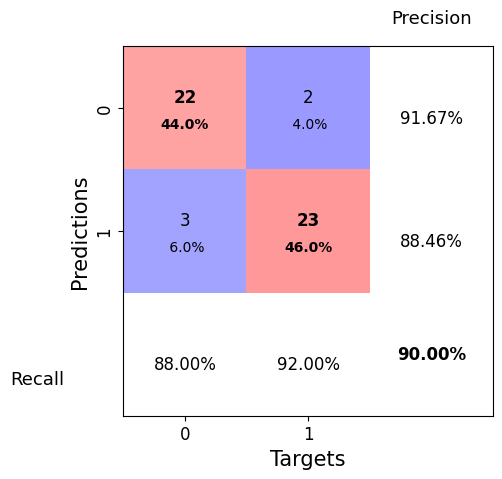

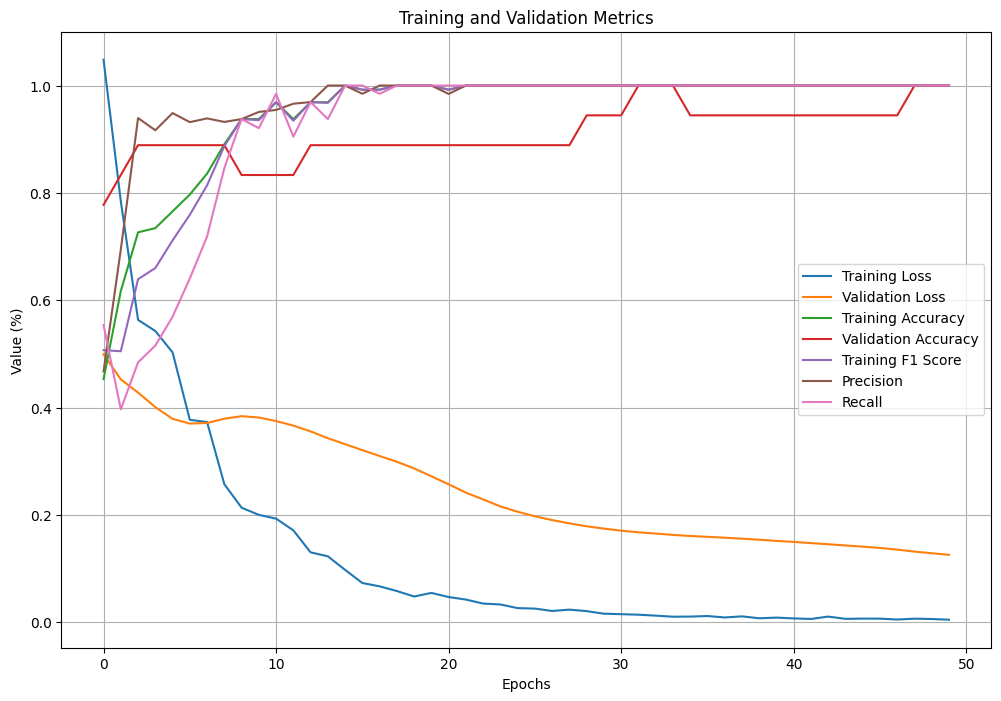

In [ ]:
#""" Figures and Plots of Data
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix
import matplotlib.pyplot as plt
from braindecode.visualization import compute_amplitude_gradients

# Manual labels dictionary for the confusion matrix
label_dict = {0: 'Left', 1: 'Right'}

# get the targets
y_true = np.array(y_test)
y_pred = np.array(y_pred)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

class_names = [label_dict[i] for i in range(len(label_dict))]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=label_dict)

#-----------------------------------------------------------------------------#
# Line plot of the training and validation metrics
#-----------------------------------------------------------------------------#

# Extract the values for the metrics
train_loss = net.history[:, 'train_loss']
valid_loss = net.history[:, 'valid_loss']
train_acc = net.history[:, 'train_acc']
valid_acc = net.history[:, 'valid_acc']
train_f1 = net.history[:, 'train_f1']
precision = net.history[:, 'train_precision']
recall = net.history[:, 'train_recall']

# Create the plot
epochs = np.arange(len(train_loss))

plt.figure(figsize=(12, 8))

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')
plt.plot(epochs, train_f1, label='Training F1 Score')
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')

plt.xlabel('Epochs')
plt.ylabel('Value (%)')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True, )
plt.show()

#-----------------------------------------------------------------------------#
# Plot the amplitude gradients
#-----------------------------------------------------------------------------#

#compute_amplitude_gradients(net.module_, X_test, net.batch_size)

In [ ]:
"""Splitting into Train, Validation, and Test Sets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Normalizing Labels to [0, 1, 2, 3]
y = labels - np.min(labels)
print(y)

# Normalizing Input features: z-score(mean=0, std=1)
X = (epoched_data - np.mean(epoched_data)) / np.std(epoched_data)
print(X)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full)

# Converting to Tensors
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_val = torch.Tensor(X_val).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_val = torch.LongTensor(y_val).to(device)
y_test = torch.LongTensor(y_test).to(device)

#Creating Tensor Datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

"""

In [ ]:
""" Function to create the EEGClassifier model
    def create_model(self, epochs, epoched_data, labels):
        from skorch.dataset import ValidSplit
        from braindecode import EEGClassifier
        from braindecode.models import ShallowFBCSPNet
        import torch
        from skorch.callbacks import EpochScoring

        # Extract the number of channels and sampling frequency from the MNE Epochs object
        n_channels = epochs.info['nchan']
        sfreq = epochs.info['sfreq']
        print(n_channels, sfreq)

        # Determine the length of the epoch in samples
        input_window_samples = len(epochs.times)  # Number of time points in each epoch
        print(input_window_samples)

        # Determine the number of classes
        n_classes = len(np.unique(labels))
        print(n_classes)

        # Define the EEGClassifier with ShallowFBCSPNet
        net = EEGClassifier(
            module=ShallowFBCSPNet,  # Pass the class itself, not a string
            module__final_conv_length='auto',
            train_split=ValidSplit(0.2),
            optimizer=torch.optim.AdamW,  # Specify the optimizer
            lr=0.001,  # Specify the learning rate
            device='cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
            callbacks=[('train_acc', EpochScoring(scoring='accuracy', on_train=True, name='train_acc'))]
        )
        print(epoched_data.shape)

        net.fit(epoched_data, labels, epochs=100)

        print(net.module_)
    """

In [ ]:
"""class TrainModel(nn.Module):
class TrainModel(nn.Module):
    def train_model(self, model, train_dataset, val_dataset, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        highest_val_accuracy = 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total

            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_accuracy = val_correct / val_total
            if val_accuracy > highest_val_accuracy:
                highest_val_accuracy = val_accuracy

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {(val_accuracy*100):.2f}%")

        print("Highest Validation Accuracy:", highest_val_accuracy)

        # Saving model
        torch.save(model.state_dict(), 'eegnet_model.pth')
        return model
    """


In [ ]:
""""class EEGClassifierEval(nn.Module):
class EEGClassifierEval(nn.Module):
    def __init__(self, model, device='cuda' if cuda.is_available() else 'cpu',
                 final_conv_length='auto', train_split=ValidSplit(0.2), optimizer=optim.AdamW,
                 lr=0.001, callbacks=[('train_acc', EpochScoring(scoring='accuracy', on_train=True,
                                             name='train_acc'))]):
        super(EEGClassifier, self).__init__()

        self.model = model
        self.device = device
        self.final_conv_length = final_conv_length
        self.train_split = train_split
        self.optimizer = optimizer
        self.lr = lr
        self.callbacks = callbacks
"""

In [ ]:
""""class ShallowFBCSPNetModel
class ShallowFBCSPNetModel(nn.Module):
    def __init__(self, chans=14, classes=2, sample_rate=128, time_duration_in_seconds=8):
        super(ShallowFBCSPNetModel).__init__()

        time_points = (sample_rate * time_duration_in_seconds)+1

    def forward(self, x):
        # Add a channel dimension (required for Conv2d)
        x = x[:, None, :, :]

        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.F.elu(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.F.elu(x)

        # Pooling and dropout
        x = self.pool1(x)
        x = self.dropout(x)

        # Flatten and classify
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x


"""


In [ ]:
"""Training, Evalualtion, Testing of Model Using Classes***
# Extract the number of channels and sampling frequency from the MNE Epochs object
n_channels = epochs.info['nchan']
sfreq = epochs.info['sfreq']
print(n_channels, sfreq)

# Determine the length of the epoch in samples
input_window_samples = len(epochs.times)  # Number of time points in each epoch
print(input_window_samples)

# Determine the number of classes
n_classes = len(np.unique(labels))
print(n_classes)

shallowFBCSPnet_model = ShallowFBCSPNetModel(n_channels, n_classes, input_window_samples)
epochs = 100

trainer = TrainModel()
trained_shallowFBCSPnet_model = trainer.train_model(shallowFBCSPnet_model, train_dataset, val_dataset, learning_rate=0.001, batch_size=64, epochs=50)
"""

In [ ]:
# Authors: Lukas Gemein <l.gemein@gmail.com>
#          Hubert Banville <hubert.jbanville@gmail.com>
#          Simon Brandt <simonbrandt@protonmail.com>
#          Daniel Wilson <dan.c.wil@gmail.com>
#
# License: BSD (3-clause)
!pip install moabb
from braindecode.datasets import MOABBDataset

In [ ]:
subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])


In [ ]:
!pip install --upgrade numpy
from numpy import multiply

from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

# Define a named function for volt-to-microvolt conversion
def convert_to_microvolts(data):
    return multiply(data, factor)

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(convert_to_microvolts),  # Convert from V to uV using the named function    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 149.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moabb 1.2.0 requires numpy<2.0,>=1.22, but you have numpy 2.2.4 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.4 which is incompatible.


In [ ]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np

In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
valid_set = splitted['1test']  # Session evaluation

In [ ]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model = model.cuda()

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 40, 1101, 1]          36,240                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 1101, 1]          [1, 40, 1101, 1]          --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 1101, 1]          [1, 40, 69, 1]            --                        [75, 1]
├─Express

/usr/local/lib/python3.11/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# We found these values to be good for the shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 50

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for the specified number of epochs. `y` is None as it is
# already supplied in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5630       0.2500            0.2500        5.7142  0.0006  0.3364
      2            0.2500        1.3054       0.2431            0.2431        6.7766  0.0006  0.3107
      3            0.2500        1.1373       0.2500            0.2500        6.1595  0.0006  0.3092
      4            0.3750        1.0034       0.2604            0.2604        4.1188  0.0006  0.3339
      5            0.2882        1.0107       0.2708            0.2708        3.2522  0.0006  0.3277
      6            0.2986        0.8107       0.2778            0.2778        2.6708  0.0006  0.3274
      7            0.4062        0.7599       0.2986            0.2986        2.0794  0.0006  0.3303
      8            0.4688        0.7134       0.3785            0.3785        1.6273  0.000

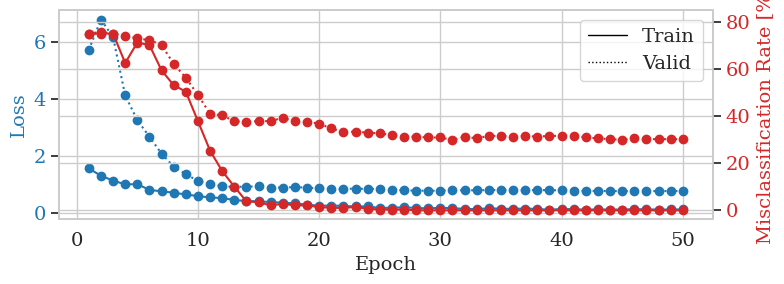

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

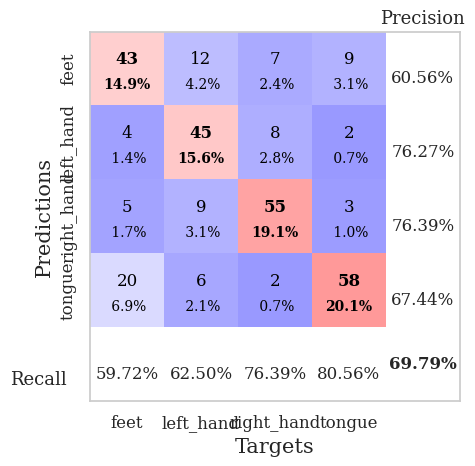

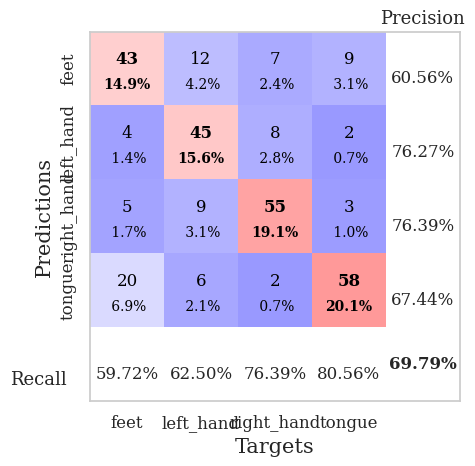

In [ ]:
from sklearn.metrics import confusion_matrix

from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = windows_dataset.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)